In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA
register_matplotlib_converters()
from time import time
from tqdm import tqdm
sns.set_theme()


### Read & Display CSV Files

In [2]:
solar_data = pd.read_csv('solar_data.csv')
census_data = pd.read_csv('census_data.csv')
gas_meter_data = pd.read_csv('gas_meter_data.csv')

In [3]:
print('HEAD', gas_meter_data.head())
print('INFO', gas_meter_data.info())
print('DESCRIPTION', gas_meter_data.describe())

HEAD    house_id  gas_meter_id  2020-01-01 00:00:00  2020-01-01 01:00:00  \
0  a90ea0b3      54363558                 0.00                 0.00   
1  049bf03c      54459969                 0.00                 0.00   
2  569aaf4b      40488619                 2.40                 2.64   
3  5edb8c2b      94746136                 0.96                 1.68   
4  0a4bda96      56809534                 0.00                 0.00   

   2020-01-01 02:00:00  2020-01-01 03:00:00  2020-01-01 04:00:00  \
0                 0.00                  0.0                 0.00   
1                 0.00                  0.0                 0.00   
2                 2.40                  2.4                 2.16   
3                 0.72                  0.0                 0.00   
4                 0.00                  0.0                 0.00   

   2020-01-01 05:00:00  2020-01-01 06:00:00  2020-01-01 07:00:00  ...  \
0                  0.0                 0.00                  0.0  ...   
1            

### Drop the house_id and gas_meter_id to focus only on time-series

In [4]:
gas_meter_data_df = gas_meter_data.drop(['house_id', 'gas_meter_id'], axis=1)
print(gas_meter_data_df.head())

   2020-01-01 00:00:00  2020-01-01 01:00:00  2020-01-01 02:00:00  \
0                 0.00                 0.00                 0.00   
1                 0.00                 0.00                 0.00   
2                 2.40                 2.64                 2.40   
3                 0.96                 1.68                 0.72   
4                 0.00                 0.00                 0.00   

   2020-01-01 03:00:00  2020-01-01 04:00:00  2020-01-01 05:00:00  \
0                  0.0                 0.00                  0.0   
1                  0.0                 0.00                  0.0   
2                  2.4                 2.16                  2.4   
3                  0.0                 0.00                  0.0   
4                  0.0                 0.00                  0.0   

   2020-01-01 06:00:00  2020-01-01 07:00:00  2020-01-01 08:00:00  \
0                 0.00                  0.0                  0.0   
1                 0.00                  0.0   

In [5]:
# Select the the first columns (entities)
selected_cols = gas_meter_data_df.iloc[:, :].columns
print(selected_cols)

Index(['2020-01-01 00:00:00', '2020-01-01 01:00:00', '2020-01-01 02:00:00',
       '2020-01-01 03:00:00', '2020-01-01 04:00:00', '2020-01-01 05:00:00',
       '2020-01-01 06:00:00', '2020-01-01 07:00:00', '2020-01-01 08:00:00',
       '2020-01-01 09:00:00',
       ...
       '2020-12-31 14:00:00', '2020-12-31 15:00:00', '2020-12-31 16:00:00',
       '2020-12-31 17:00:00', '2020-12-31 18:00:00', '2020-12-31 19:00:00',
       '2020-12-31 20:00:00', '2020-12-31 21:00:00', '2020-12-31 22:00:00',
       '2020-12-31 23:00:00'],
      dtype='object', length=8784)


In [6]:
# First revert to full datetime column names if needed
gas_meter_data_df.columns = [pd.to_datetime(col).strftime('%m/%d/%Y %H:%M') for col in gas_meter_data_df.columns]

# Convert the full datetime strings to just the hour of the day (note: this will average the measurements across all days for the same hour)
gas_meter_data_time_only_df = gas_meter_data_df.groupby([pd.to_datetime(col).strftime('%H:%M') for col in gas_meter_data_df.columns], axis=1).mean()


In [7]:
print(gas_meter_data_time_only_df.head())

      00:00     01:00     02:00     03:00     04:00     05:00     06:00  \
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2  0.820328  0.846557  0.851803  0.883934  0.898361  0.918033  0.925246   
3  0.263607  0.336393  0.309508  0.261639  0.205902  0.200000  0.246557   
4  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

      07:00     08:00     09:00  ...     14:00     15:00     16:00     17:00  \
0  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
1  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
2  0.955410  0.965902  0.979672  ...  0.737049  0.670164  0.664918  0.631475   
3  0.321967  0.363934  0.443934  ...  0.529836  0.397377  0.367869  0.316721   
4  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   

      18:00     19:00     20:00     21:00     22:00     23:00  
0  0

In [8]:
def detect_outliers(row):
    Q1 = row.quantile(0.25)
    Q3 = row.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = row[(row < lower_bound) | (row > upper_bound)]
    return outliers

# Function to replace outliers with the mean of the non-outlier values of the row
def replace_outliers(row):
    Q1 = row.quantile(0.25)
    Q3 = row.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Calculate mean excluding outliers
    mean = row[(row >= lower_bound) & (row <= upper_bound)].mean()
    
    # Replace outliers with the mean
    row[(row < lower_bound) | (row > upper_bound)] = mean
    return row


In [9]:
# Apply the function to each row
outlier_detection = gas_meter_data_time_only_df.apply(detect_outliers, axis=1)
# Apply the function to each row to replace outliers
gas_meter_data_time_only_df = gas_meter_data_time_only_df.apply(replace_outliers, axis=1)
print(gas_meter_data_time_only_df.head())



      00:00     01:00     02:00     03:00     04:00     05:00     06:00  \
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2  0.820328  0.846557  0.851803  0.883934  0.898361  0.918033  0.925246   
3  0.263607  0.336393  0.309508  0.261639  0.205902  0.200000  0.246557   
4  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

      07:00     08:00     09:00  ...     14:00     15:00     16:00     17:00  \
0  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
1  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
2  0.955410  0.965902  0.979672  ...  0.737049  0.670164  0.664918  0.631475   
3  0.321967  0.363934  0.443934  ...  0.529836  0.397377  0.367869  0.316721   
4  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   

      18:00     19:00     20:00     21:00     22:00     23:00  
0  0

In [10]:
print(gas_meter_data_time_only_df.head())


      00:00     01:00     02:00     03:00     04:00     05:00     06:00  \
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2  0.820328  0.846557  0.851803  0.883934  0.898361  0.918033  0.925246   
3  0.263607  0.336393  0.309508  0.261639  0.205902  0.200000  0.246557   
4  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

      07:00     08:00     09:00  ...     14:00     15:00     16:00     17:00  \
0  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
1  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
2  0.955410  0.965902  0.979672  ...  0.737049  0.670164  0.664918  0.631475   
3  0.321967  0.363934  0.443934  ...  0.529836  0.397377  0.367869  0.316721   
4  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   

      18:00     19:00     20:00     21:00     22:00     23:00  
0  0

In [11]:
# Normalize each row in the DataFrame to range from 0 to 1
normalized_df = gas_meter_data_time_only_df.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)

# Fill NaN values that result from rows where max == min with 0 (or any appropriate value indicating no variation)
normalized_df = normalized_df.fillna(0)

# Show the first few rows to verify normalization
print(normalized_df.head())


      00:00     01:00     02:00     03:00     04:00     05:00     06:00  \
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2  0.578125  0.647569  0.661458  0.746528  0.784722  0.836806  0.855903   
3  0.112922  0.242142  0.194412  0.109430  0.010477  0.000000  0.082654   
4  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

      07:00     08:00     09:00  ...     14:00     15:00     16:00     17:00  \
0  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
1  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
2  0.935764  0.963542  1.000000  ...  0.357639  0.180556  0.166667  0.078125   
3  0.216531  0.291036  0.433062  ...  0.585565  0.350407  0.298021  0.207218   
4  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   

      18:00     19:00     20:00     21:00     22:00     23:00  
0  0

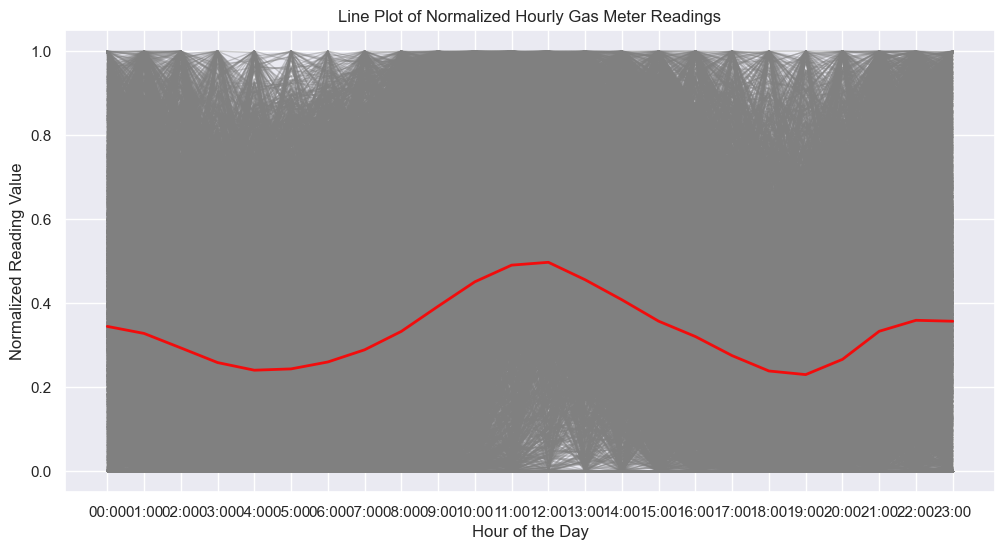

In [12]:
plt.figure(figsize=(12, 6))
for index, row in normalized_df.iterrows():
    plt.plot(row.index, row, marker='', color='grey', linewidth=1, alpha=0.4)
mean_line = normalized_df.mean()
plt.plot(mean_line.index, mean_line, marker='', color='red', linewidth=2, alpha=0.9)
plt.title('Line Plot of Normalized Hourly Gas Meter Readings')
plt.xlabel('Hour of the Day')
plt.ylabel('Normalized Reading Value')
plt.xticks(ticks=range(24), labels=[f"{i:02d}:00" for i in range(24)])
plt.show()


In [13]:
meter_data = pd.read_csv("meter_data.csv")

KeyboardInterrupt: 